# Section 7. Neural Network Bigram Model

- Previously we saw how logistic regression weights are equivalent to bigram probabilities derived from the counting method 
- This lecture we will build on this by building a MULTI LAYER neural network! Lets do a quick review now:

### Neural Network Bigram model
- the 'old' model is just the logistic regression function with softmax
- the new model include two sets of weights (which is transformed by tanh), and then a final softmax function which is similar to the logistic function
- remember, the way we represent the X and y variables DOES NOT CHANGE.
    - The output is still p(y | x)... prob of y given X


![](pictures/nlp_7_nnet.jpg)

### Categorical Cross Entropy
- For training, the algorithm is pretty much the same. 
- The cost function is **EXACTLY** the same (categorical cross entropy). 
- **THE ONLY DIFFERENCE is that we have to update  BOTH W1 AND W2**. This means that the gradient calculations will be slightly different (also because we are using tanh).

![](pictures/nlp_7_nnetcost.jpg)

### Gradients of Cost function
- Below is the equation of the W gradients for Categorical Cross Entropy *(assuming tanh activation is used)*. **Look at the ann_class/backprop.py lecture for an example!**
- As per convention, we use lowercase (eg, x, h) to mean a single vector, and uppercase (eg, X, H) to mean a matrix (batch) containing multiple vectors.
- Note that the circled dot notation means 'element wise multiplication'

![](pictures/nlp_7_nnetgrad.jpg)

### Why not use Tensorflow/Theano for gradient calcs?
- Short answer: efficiency, we can improve our code in TF if we now how this stuff works!

### Hyperparameters
- Always something you need to think about in deep learning / neural networks
- More expressiveness, less robustness, when compared to linear models
- What should the hidden layer size (D) be?
    - shape(W1)==VxD
    - shape(W2)==DXV
- D is the size of the hidden layer, and is an **arbitrary hyperparameter**
- In this case, we want **D to be MUCH SMALLER than V**. There are multiple reasons for this: 
    - Autoencoder pattern: Bottleneck shape compresses V dimensions into D dimensions
    - **In this way, neural nets learn A USEFUL AND EFFICIENT FEATURE REPRESENTATION of the raw inputs**
![](pictures/nlp_7_autoencode.jpg)


### Logistic Regression
- Recall that our Logistic Regression language model in the last exercise was super slow. Training time was... **LOL A FULL DAY.... OOOOOPS DEF FORGOT TO TURN THAT BAD BOY ODD...**
- Anyway, the reason it is so slow is because there are so many god danm weights. 
- So imagine we had a vocab of 10,000
    - the weights vector would be V\*V = 10^8 (100 milllllion), which is stupid
- How many weights would be in our neural net with a vocab of 10,000
    - If we set D = 100
    - Both weights would have (10^2)x(10^4).. (100)X(10,000) = 1,000,000
    - So total we have 2 million weights! 
    - We multiply by 2 because we first shrink to 100 neurons, than increase back up to 10,000
    
- By using a neural network, we get a 50 - 1 compression ratio!!! Shit is dope.
    
### Bigrams Porbabilities
- Just like logistic regression weights were a model for bigram probailities using counting, so are the neural net weights! 
- Well, if you look at how the weights combine, you can get an approximation of W. And since only contains 1s and 0s we can effectively ignore it. 

![](pictures/nlp_7_nnet2.jpg)



# Let's write some code!

We are generally going to be copying a lot of code from the past lecture so we will import that below.

# 1. Import old code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os
import sys
from nltk.corpus import brown
import nltk
import operator

#GET SENTENCES FROM BROWN CORPUS
def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()
test = get_sentences()

#SENTANCES TO INDEX REPRESENTATION
def get_sentences_with_word2idx(print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    
    #loop through all sentances, add unique words to index
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            #convert each sentance to index map
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    if print_v:
        print("Vocab size:", i)
    return indexed_sentences, word2idx

#SENTANCES TO INDEX REPRESENTATION WITH LIMITED VOCAB
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS, print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    
    #Set start tokens to inf so they dont get removed when sorting by count
    word_idx_count = {
    0: float('inf'),
    1: float('inf'),
    }
    
    #Count each word 
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1
            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size
    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')
    #tell sorted funciton to use 2nd item to sort
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    #create new dictionary from old dict
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        if print_v:
            print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    # replcae all infrequent words are replaced with 'UNKOWN"
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx
    
    # sanit check to make sure all words wanted to keep are still there
    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

def get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # initialize bigram_probs with size vocab * vocab
    # set all values as 1s and multiple mby smoothing (this will ensure minimum values is 1*smoothing value)
    bigram_probs = np.ones((V, V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            # begining word... add 1 to col row[0] (previous word) and col[i] (current word)
            # we loop through sentence items because they are in indexed format, so we can use values as indeces
            if i==0:
                bigram_probs[start_idx, sentence[i]] += 1
            else: #middle word
                bigram_probs[sentence[i-1], sentence[i]] += 1
            # if we're at the final word
            # we update the bigram for last -> current, AND current -> END token
            if i == len(sentence) - 1: # END word
                bigram_probs[sentence[i], end_idx] += 1
    # normalize the counts along the rows to get probabilities
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs

def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1-decay) * x[t]
        y[t] = z / (1 - decay ** (t+1))
        last = z
    return y

In [12]:
#import data
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(5000)

#extract dimensions
V = len(word2idx)
start_idx = word2idx['START']
end_idx = word2idx['END']
bigram_probs = get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=0.1)
print('Vocab length: ', V)
print('Start index: ', start_idx)
print('End index: ', end_idx)
print('Bigram probs:',bigram_probs[0:5].shape)

# what is the loss if we set W = log(bigram_probs)?
W_bigram = np.log(bigram_probs)


Vocab length:  5001
Start index:  0
End index:  1
Bigram probs: (5, 5001)


# 2. Train and run neural net model

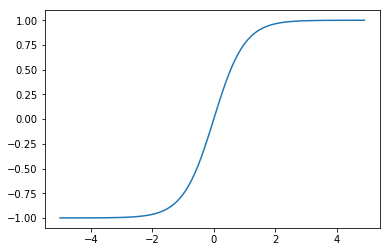

In [30]:
#remember, we are using the tanh function here.
x = np.arange(-5,5,0.1)
y = np.tanh(x)
plt.plot(x,y)
plt.show()

In [43]:
# train a shallow neural network model
# D is hidden layer which compresses the data to from size V to D
D = 100 
#initialize random weights
W1 = np.random.randn(V,D) / np.sqrt(V)
W2 = np.random.randn(D,V) / np.sqrt(D)

losses = []
bigram_losses = []
epochs = 1
lr = 1e-2

t0 = datetime.now()
for epoch in range(epochs):
    #randomize sentences
    random.shuffle(sentences)
    
    j = 0 #keep track of iterations
    # remember, we treat each sentence kind of like a minibatch, which is why we get such wild variations in loss
    #only take 10k sentences
    for sentence in sentences[0:10000]:
        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence)
        inputs = np.zeros((n-1, V)) 
        targets = np.zeros((n-1, V))
        inputs[np.arange(n - 1), sentence[:n-1]] = 1 #take preceding word as inputs
        targets[np.arange(n - 1), sentence[1:]] = 1 #take current word as target
        # get output predictions
        # x.dot(weighs1), run it through tanh function and we have hidden layer! 
        hidden = np.tanh(inputs.dot(W1))
        # h.dot(weights2), run that through softmax and we have prediction probabilities!
        predictions = softmax(hidden.dot(W2))
        
        # do a gradient descent step
        # WE UPDATE W2 FIRST, THEN W1.. backprop 101
        W2 = W2 - lr * hidden.T.dot(predictions - targets)
        dhidden = (predictions - targets).dot(W2.T) * (1 - hidden * hidden)
        W1 = W1 - lr * inputs.T.dot(dhidden)

        # keep track of the loss
        loss = -np.sum(targets * np.log(predictions)) / (n - 1)
        losses.append(loss)

        # keep track of the bigram loss
        # only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_predictions = softmax(inputs.dot(W_bigram))
            bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1)
            bigram_losses.append(bigram_loss)
 
        if j % 100 == 0:
            print("epoch:", epoch, "sentence: {}/{}".format(j, len(sentences),"loss:",loss))
        j+=1

print('Elapsed training time:', datetime.now() - t0)

epoch: 0 sentence: 0/57013
epoch: 0 sentence: 100/57013
epoch: 0 sentence: 200/57013
epoch: 0 sentence: 300/57013
epoch: 0 sentence: 400/57013
epoch: 0 sentence: 500/57013
epoch: 0 sentence: 600/57013
epoch: 0 sentence: 700/57013
epoch: 0 sentence: 800/57013
epoch: 0 sentence: 900/57013
epoch: 0 sentence: 1000/57013
epoch: 0 sentence: 1100/57013
epoch: 0 sentence: 1200/57013
epoch: 0 sentence: 1300/57013
epoch: 0 sentence: 1400/57013
epoch: 0 sentence: 1500/57013
epoch: 0 sentence: 1600/57013
epoch: 0 sentence: 1700/57013
epoch: 0 sentence: 1800/57013
epoch: 0 sentence: 1900/57013
epoch: 0 sentence: 2000/57013
epoch: 0 sentence: 2100/57013
epoch: 0 sentence: 2200/57013
epoch: 0 sentence: 2300/57013
epoch: 0 sentence: 2400/57013
epoch: 0 sentence: 2500/57013
epoch: 0 sentence: 2600/57013
epoch: 0 sentence: 2700/57013
epoch: 0 sentence: 2800/57013
epoch: 0 sentence: 2900/57013
epoch: 0 sentence: 3000/57013
epoch: 0 sentence: 3100/57013
epoch: 0 sentence: 3200/57013
epoch: 0 sentence: 330

# 3. Visualize data

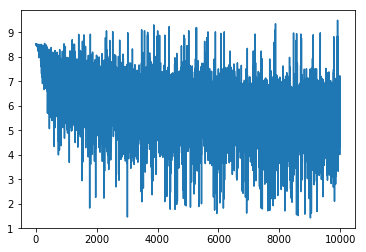

In [44]:
#plot losses to make sure model is working right
plt.plot(losses)
plt.show()

avg_bigram_loss: 4.50519154333


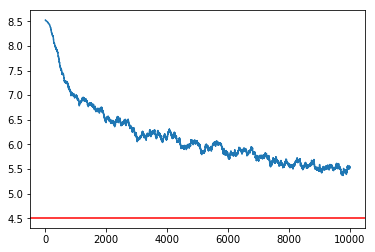

In [45]:
# plot a horizontal line for the bigram loss
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')

plt.plot(smoothed_loss(losses))
plt.show()

# Conclusion

The model is much faster (due to the fewer weights) and converges at about the same rate!